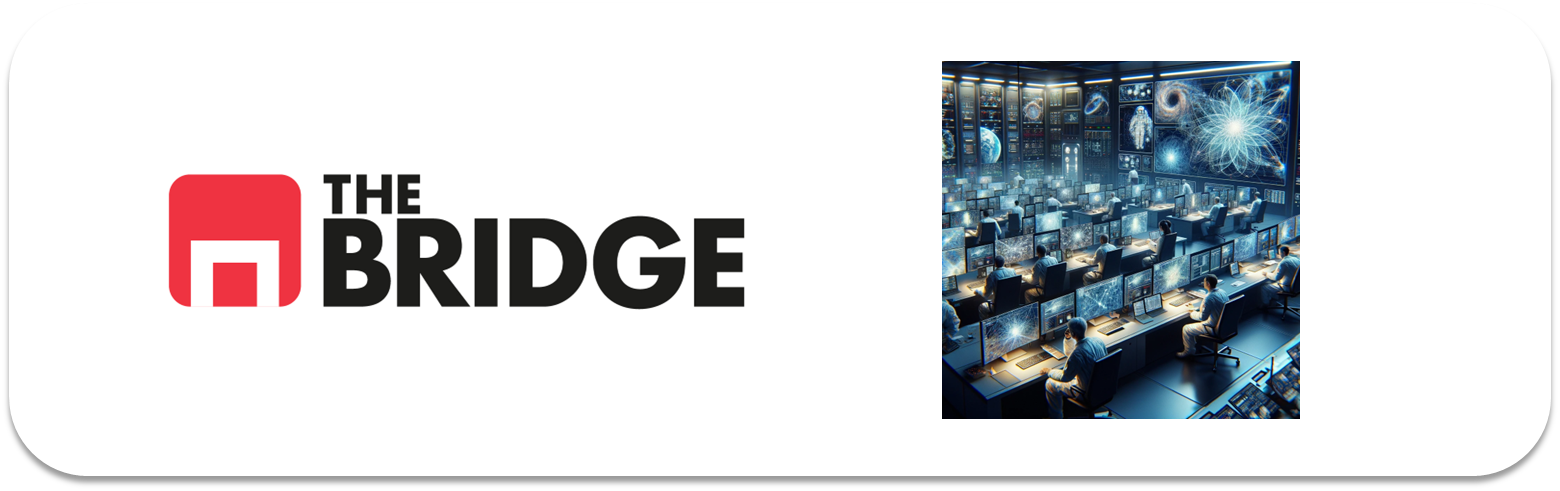

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import zipfile
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from keras.applications import InceptionV3
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [2]:
def read_data_from_zip(zip_path, reshape_dim=(75, 75)):
    X = [] 
    y = []
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Listar los nombres de archivos en el ZIP
        for file in zip_ref.namelist():
            if file.endswith('/'):  # Ignorar directorios
                continue
            
            folder_name = os.path.basename(os.path.dirname(file))  # Nombre de la carpeta
            with zip_ref.open(file) as img_file:
                image = cv2.imdecode(np.frombuffer(img_file.read(), np.uint8), cv2.IMREAD_COLOR)
                if image is not None:
                    image = cv2.resize(image, reshape_dim)  # Redimensionamos las imágenes
                    X.append(image)
                    y.append(folder_name)

    return np.array(X), np.array(y)

def show_images_batch(images, names=[], n_cols=5, size_scale=2):
    n_rows = (len(images) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1 * size_scale))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convertir BGR a RGB
        plt.axis("off")
        if len(names):
            plt.title(names[index])
    plt.tight_layout()
    plt.show()

# Ruta del archivo ZIP
ZIP_PATH = r"C:\Users\DMIN\Desktop\The Bridge\Revisiones\05_Deep_Learning\Sprint 17 - DL aplicado a Imágenes\Unidad 2. Redes Convolucionales II Transfer Learning y Fine-Tuning\data.zip"

# Leer datos de entrenamiento y prueba
X_train,y_train = read_data_from_zip(ZIP_PATH)
X_test, y_test = read_data_from_zip(ZIP_PATH)



In [3]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (24335, 75, 75, 3)
Y train shape:  (24335,)


In [4]:
print('X test shape: ', X_test.shape)
print('Y test shape: ', y_test.shape)

X test shape:  (24335, 75, 75, 3)
Y test shape:  (24335,)


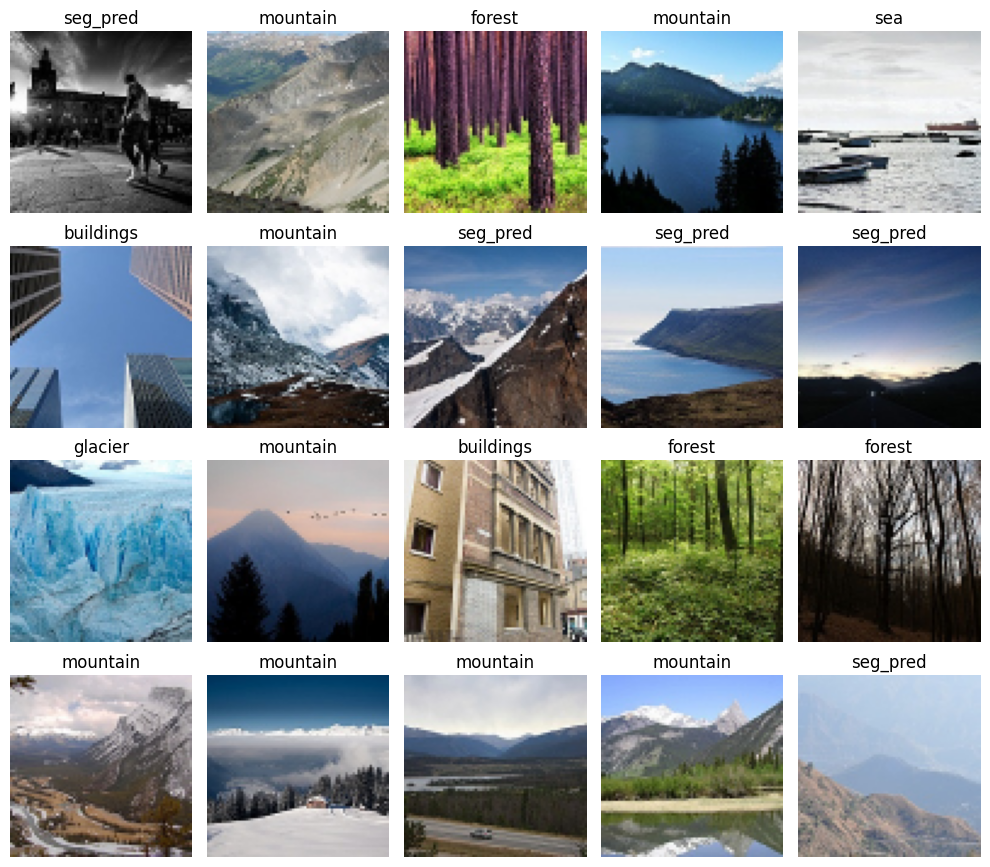

In [5]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [6]:
X_train = X_train/255
X_test = X_test/255

In [7]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(75, 75, 3))

for layer in base_model.layers:
    layer.trainable = False

def prepare_model(base_model = base_model): 
    x = keras.layers.Flatten()(base_model.output)
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)
    x = keras.layers.Dense(6, activation='softmax')(x)
    model = keras.Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc']) # sparse -> y es un array de escalares pero hay varias categorias, y un array de vectores
    return model

In [8]:
model = prepare_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 37, 37,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 37, 37,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 35, 35,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 35, 35,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 17, 17,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 17, 17,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 15, 15,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 4,208,646 (16.05 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [9]:
targets = pd.Series(y_train)
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{'seg_pred': 0,
 'buildings': 1,
 'forest': 2,
 'glacier': 3,
 'mountain': 4,
 'sea': 5,
 'street': 6}

In [11]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [13]:
X_train, y_train_num = shuffle(X_train, y_train_num)

In [14]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 25,
                    batch_size = 128, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)])

Epoch 1/25


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1986, in _run_once

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\DMIN\AppData\Local\Temp\ipykernel_392\1105132308.py", line 1, in <module>

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 371, in fit

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 219, in function

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 132, in multi_step_on_iterator

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 113, in one_step_on_data

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 60, in train_step

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 383, in _compute_loss

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\trainer.py", line 351, in compute_loss

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 691, in __call__

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\compile_utils.py", line 700, in call

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\loss.py", line 67, in __call__

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 33, in call

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\losses\losses.py", line 2246, in sparse_categorical_crossentropy

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\ops\nn.py", line 1963, in sparse_categorical_crossentropy

  File "c:\Users\DMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 744, in sparse_categorical_crossentropy

Received a label value of 6 which is outside the valid range of [0, 6).  Label values: 0 2 1 2 4 6 0 6 0 6 6 3 6 4 3 3 0 2 4 0 1 1 0 2 2 1 2 5 0 3 0 2 0 6 5 2 4 5 0 0 0 6 1 1 1 0 1 0 3 4 3 0 2 0 0 0 0 3 0 4 2 0 0 0 4 2 2 0 3 3 6 0 1 2 3 0 6 2 0 4 0 0 2 3 2 2 4 6 0 2 2 1 0 6 5 2 1 2 0 3 5 1 0 4 0 0 1 1 5 0 3 0 0 4 0 2 1 0 6 0 3 5 5 0 2 5 4 4
	 [[{{node compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_multi_step_on_iterator_13087]